## Core Image Segmentaion

#### Core Images 

##### Core analysis is the primary method providing precise and measurable insights into the characteristics of oil and gas reservoirs. It forms the foundation for assessing formations, essential in developing both static and dynamic reservoir models. However, there is a significant issue with much of this valuable data being confined within folders and outdated documents. The capacity to liberate this data and integrate it with other seemingly disparate data types is immensely valuable.

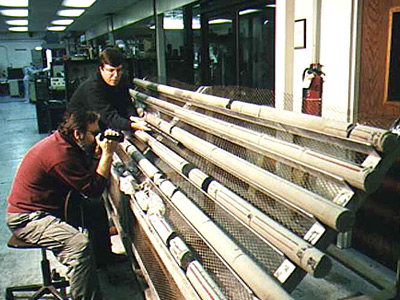

###### Examining Core Samples Source: US Department of Energy, N.E.T.L

### Data Acknowledgement

###### Thnk you to EDA and Data Hub for providing the core images 

## Data loading and visualisation 

##### Let's load a core image and have a look:

### Import libraries

In [26]:
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

#### Core image

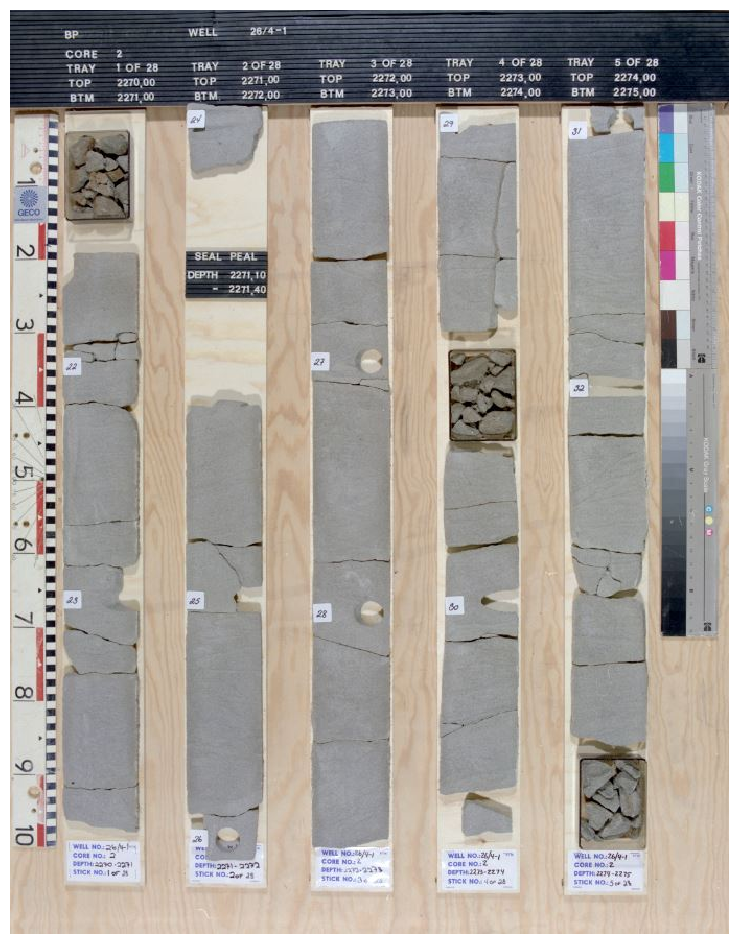

In [27]:
core_image = Image.open(r'./core_no_notes.JPG')

plt.figure(figsize=(12, 12))
plt.imshow(core_image)
plt.axis('off')  
plt.show()


##### Raw and labeled images serve to emphasize essential features. However, accommodating various formats from different laboratories presents part of our challenge today.

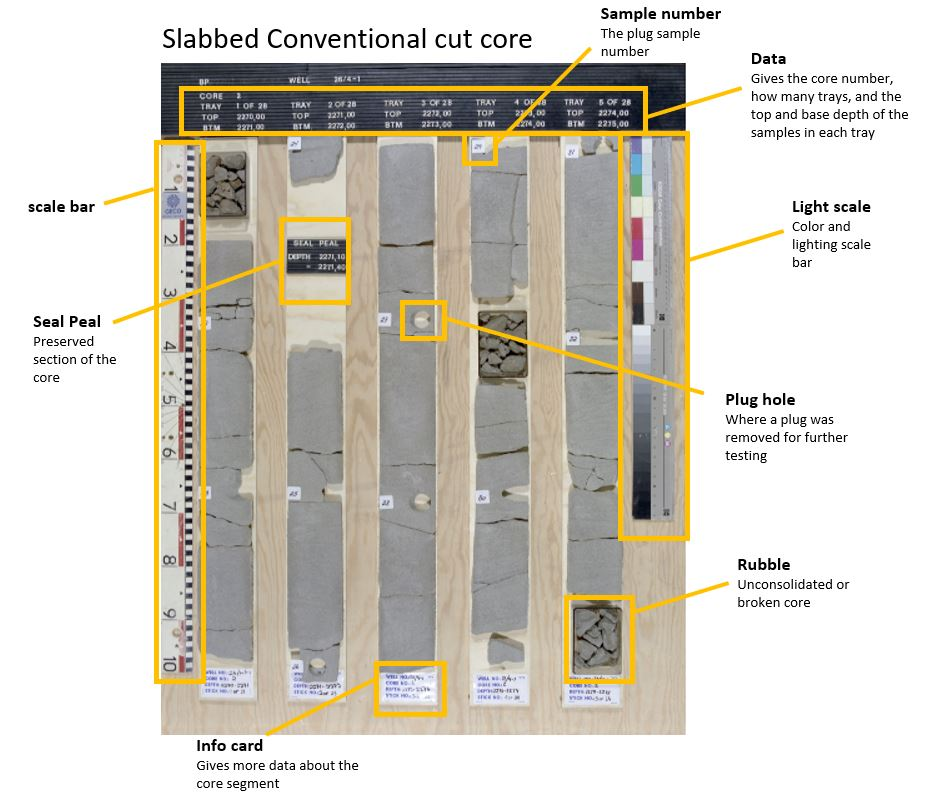

#### Installing the Segment Anything Model (SAM)


In [28]:
# pip install git+https://github.com/facebookresearch/segment-anything.git  #segment anything installation
# pip install opencv-python pycocotools matplotlib onnxruntime onnx # dependancies 

# # or clone the repo with:
# # git clone git@github.com:facebookresearch/segment-anything.git
# # cd segment-anything; pip install -e .

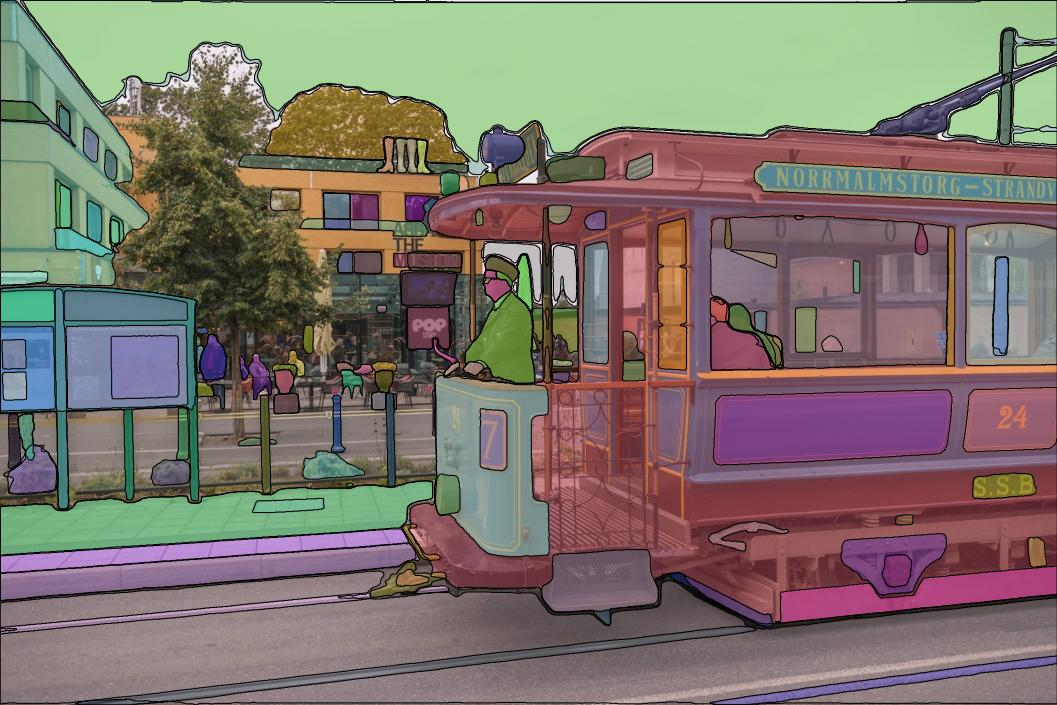

###### The Segment Anything Model (SAM) produces high quality object masks from input prompts such as points or boxes, and it can be used to generate masks for all objects in an image.

### The challenge:

##### Here's the hackathon challenge: __Segment the individual core segments from the images, identify if the images are in normal or UV light, make an assesment of the image quality and capture where plugs have been taken.__ 



### Your turn!

##### There is no rule on how you start this task. We've included some of the installation methods for the Segment Anything Model (SAM) - a model that has been trained on a data set of over 11 million images and 1.1 billion masks. More information abotu this model can be found here:  https://github.com/facebookresearch/segment-anything or here https://segment-anything.com/ but you can use any model for the segmentation. Ask as many questions as you like. We can help with installation and give you more information on core images and geology.

In [29]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

mask_generator = SamAutomaticMaskGenerator(sam)

In [30]:
core_image_np = np.array(core_image)
masks = mask_generator.generate(core_image_np)

In [52]:
print(len(masks))
print(masks[0].keys())
# print(core_image_np.shape)
# for mask in masks:
#     print(mask["bbox"])
#     print(mask["segmentation"].shape)

140
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
[0, 0, 686, 94]
(885, 688)
[539, 559, 67, 67]
(885, 688)
[413, 601, 72, 92]
(885, 688)
[289, 239, 71, 62]
(885, 688)
[537, 625, 71, 79]
(885, 688)
[290, 699, 72, 102]
(885, 688)
[535, 408, 74, 111]
(885, 688)
[53, 115, 62, 86]
(885, 688)
[289, 104, 72, 134]
(885, 688)
[168, 230, 77, 45]
(885, 688)
[51, 744, 71, 42]
(885, 688)
[51, 636, 71, 109]
(885, 688)
[535, 370, 72, 36]
(885, 688)
[290, 601, 72, 99]
(885, 688)
[412, 671, 72, 79]
(885, 688)
[415, 470, 69, 43]
(885, 688)
[533, 804, 74, 41]
(885, 688)
[412, 803, 74, 40]
(885, 688)
[534, 116, 73, 178]
(885, 688)
[51, 232, 71, 88]
(885, 688)
[52, 594, 68, 41]
(885, 688)
[52, 377, 70, 115]
(885, 688)
[415, 418, 68, 59]
(885, 688)
[54, 795, 70, 40]
(885, 688)
[411, 108, 72, 37]
(885, 688)
[409, 104, 75, 204]
(885, 688)
[538, 514, 65, 47]
(885, 688)
[52, 334, 70, 46]
(885, 688)
[535, 309, 71, 44]
(885, 688)
[52, 489, 70, 44]
(885

In [32]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

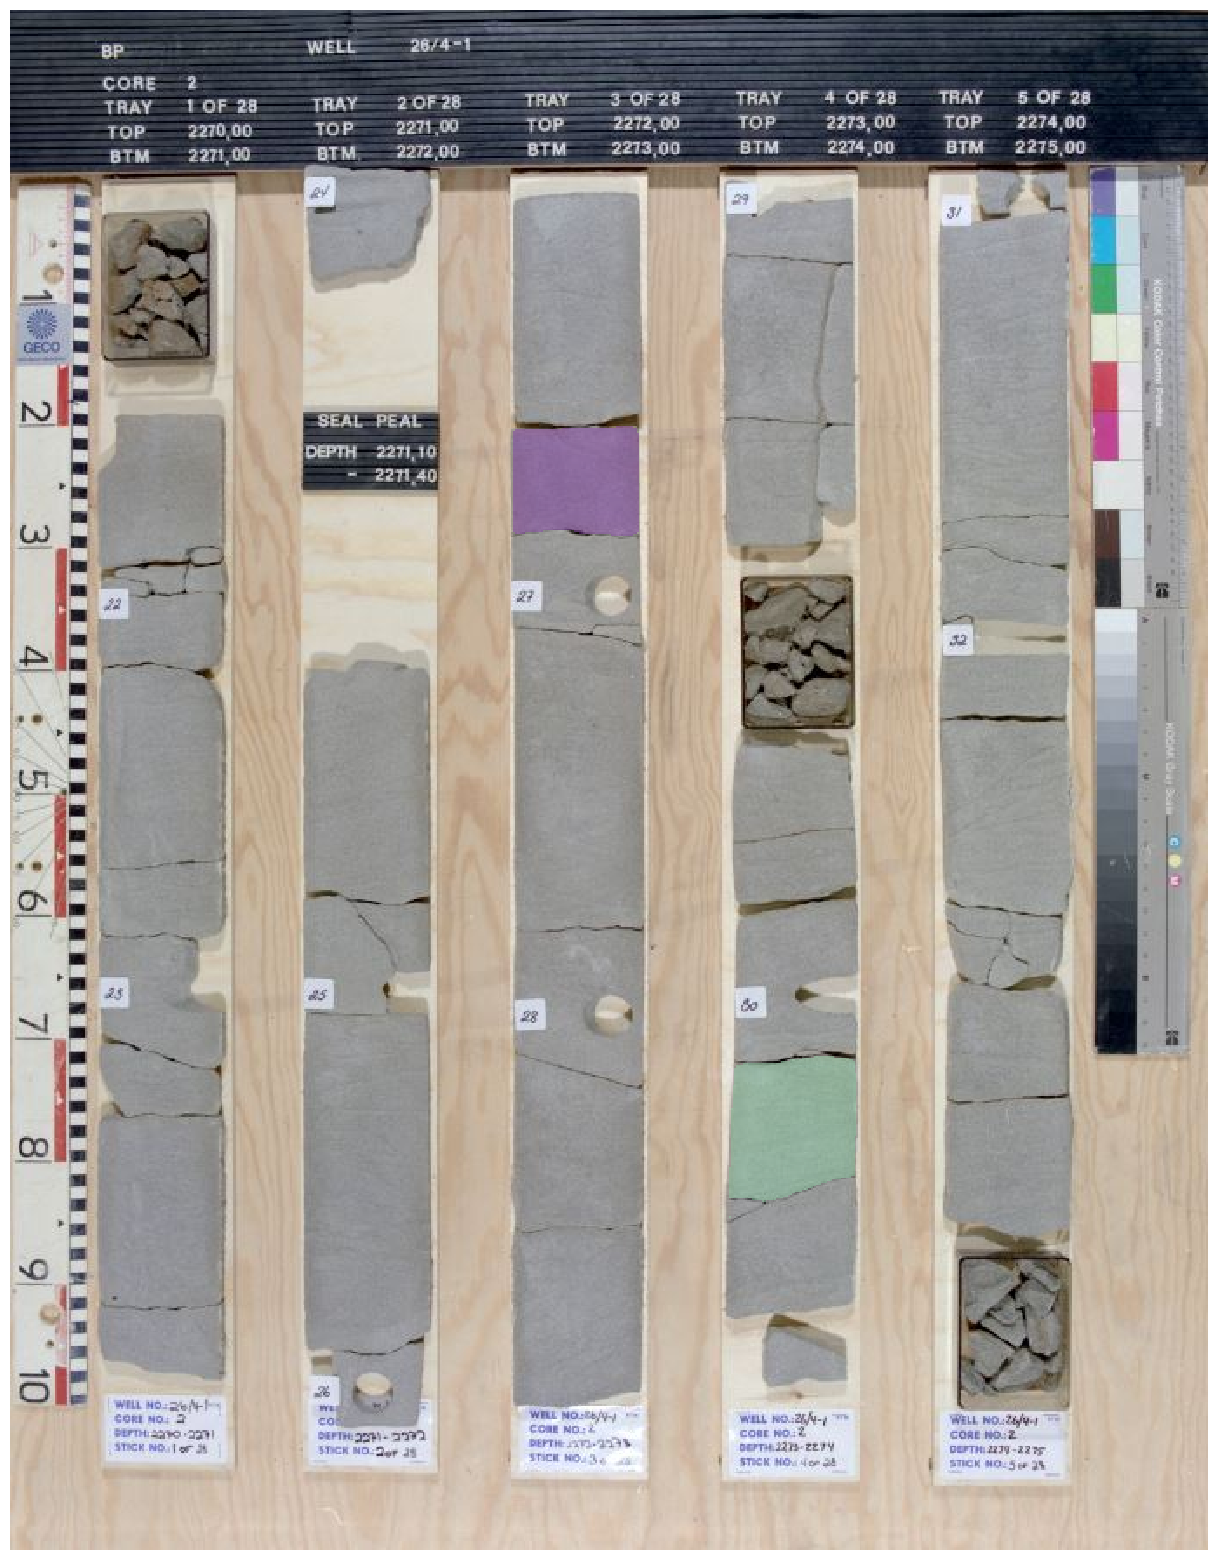

In [47]:
plt.figure(figsize=(20,20))
plt.imshow(core_image)
show_anns(masks[2:4])
plt.axis('off')
plt.show() 

In [44]:
masks[2:3]

[{'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 5369,
  'bbox': [413, 601, 72, 92],
  'predicted_iou': 1.0087769031524658,
  'point_coords': [[419.25, 622.265625]],
  'stability_score': 0.983718752861023,
  'crop_box': [0, 0, 688, 885]}]

In [45]:
masks[3:4]

[{'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 4332,
  'bbox': [289, 239, 71, 62],
  'predicted_iou': 1.003908395767212,
  'point_coords': [[311.75, 290.390625]],
  'stability_score': 0.9935543537139893,
  'crop_box': [0, 0, 688, 885]}]

In [2]:
for i, mask in enumerate(masks):
    # 将掩码转换为uint8类型，以便应用于图像
    mask_uint8 = (mask["segmentation"] * 255).astype(np.uint8)
    
    # 创建一个与原始图像相同大小的黑色图像
    segmented_img = np.zeros_like(core_image_np)
    
    # 使用掩码提取对应的分割区域
    # 注意：mask_uint8[:, :, None] 将掩码扩展为与原始图像相同的维度，如果需要
    segmented_img[mask_uint8 > 0] = core_image_np[mask_uint8 > 0]
    
    # 保存分割后的区域为图片
    save_path = f'./data/segmented_area_{i}.jpg'  # 更新保存路径
    cv2.imwrite(save_path, segmented_img)

    print(f'Saved segmented area {i} to {save_path}')

NameError: name 'masks' is not defined

In [59]:
image2 = Image.open(r'./6d684C41l0f3(1).tif')
image2_np = np.array(image2)

In [60]:
import cv2

def identify_light_type(image):
    # 将图像转换为HSV色彩空间
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # 计算HSV各通道的平均值
    h_mean, s_mean, v_mean = cv2.mean(image_hsv)[:3]
    
    # 基于经验规则判断光照类型
    if s_mean > 50 and v_mean > 50:  # 假设UV光下的图像具有更高的饱和度和亮度
        return "UV Light"
    else:
        return "Normal Light"

# 调用函数
light_type = identify_light_type(image2_np)
print(f"Light Type: {light_type}")

Light Type: Normal Light


In [55]:
def evaluate_image_quality(image):
    # 将图像转换为灰度
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 计算拉普拉斯算子
    laplacian_var = cv2.Laplacian(image_gray, cv2.CV_64F).var()
    
    # 基于经验规则判断图像质量
    if laplacian_var > 300:  # 这个阈值可能需要根据你的图像数据进行调整
        return "High Quality"
    else:
        return "Low Quality"

# 调用函数
image_quality = evaluate_image_quality(core_image_np)
print(f"Image Quality: {image_quality}")

Image Quality: High Quality
